![Codenation](https://forum.codenation.com.br/uploads/default/original/2X/2/2d2d2a9469f0171e7df2c4ee97f70c555e431e76.png)

__Autor__: Kazuki Yokoyama (kazuki.yokoyama@ufrgs.br)

# _Feature engineering_

![cover](https://venturebeat.com/wp-content/uploads/2018/07/feature_engineering.jpg?resize=680%2C198&strip=all)

Neste módulo, trabalharemos a engenharia de _features_, que consiste em preparar os nossos dados para alimentar os algoritmos de ML adequadamente. Ao contrário do mundo dos tutoriais, na vida real os dados dificilmente estarão prontos para serem consumidos. Grande parte do tempo de um projeto de ML é gasto com a engenharia de _features_, e quanto melhor a qualidade desta etapa, maiores são as chances de melhores resultados nas etapas seguintes.

## Importação das bibliotecas

In [26]:
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)

In [27]:
# Algumas configurações para o matplotlib (função para setar o matplotlib).
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 12)

sns.set()

In [28]:
np.random.seed(1000)

## _One-hot encoding_

Até aqui, nós praticamente ignoramos a existência de variáveis categóricas. Focamos nas variáveis numéricas porque elas são simples de lidar e bastante comuns. Ainda assim, variáveis categóricas são encontradas facilmente e precisamos de uma forma de trabalhar com elas.

Uma das formas mais simples de representação de variáveis categóricas é através do método chamado _one-hot enconding_. Com ele, uma variável categórica com $h$ categorias é transformada em $h$ novas variáveis binárias (0 ou 1), onde a presença do 1 (_hot_) significa que aquela observação pertence àquela categoria, e 0 (_cold_) que não pertence. Veja um exemplo abaixo:

In [29]:
# Criação de um dataset
rows = 100

height = np.random.normal(loc=1.70, scale=0.2, size=rows).round(3)
score = np.random.normal(loc=7, scale=1, size=rows).round(2)
courses = ["Math", "Physics", "Biology"]
course = np.random.choice(courses, size=rows)

data = pd.DataFrame({"Height": height, "Score": score, "Course": course})

data.head(10)

,Height,Score,Course
0,1.539,6.61,Biology
1,1.764,6.42,Biology
2,1.695,8.95,Biology
3,1.829,5.14,Biology
4,1.640,6.43,Physics
5,1.778,7.98,Physics
6,1.679,7.90,Biology
7,1.604,6.76,Physics
8,1.819,7.44,Physics
9,1.607,6.01,Physics


Criamos um _data set_ que contém duas variáveis numéricas (`Height` e `Score`) e uma variável categórica (`Course`). Nosso objetivo com o _one-hot encoding_ é transformar a variável `Course` em uma sequência de variáveis numéricas binárias, cada uma descrevendo uma classe da variável. Neste caso, como temos três categorias para `Course` (Biology, Physics e Math), teremos três novas variáveis binárias.

Vamos treinar esse _encoder_:

In [30]:
one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)

#one_hot_encoder.fit(data[["Course"]])

#course_encoded = one_hot_encoder.transform(...)

course_encoded = one_hot_encoder.fit_transform(data[["Course"]])

course_encoded[:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [31]:
# Uma alternativa é utilizar o pd.get_dummies
pd.get_dummies(data)

,Height,Score,Course_Biology,Course_Math,Course_Physics
0,1.539,6.61,1,0,0
1,1.764,6.42,1,0,0
2,1.695,8.95,1,0,0
3,1.829,5.14,1,0,0
4,1.640,6.43,0,0,1
...,...,...,...,...,...
95,1.864,6.83,0,1,0
96,2.018,6.47,0,0,1
97,1.648,7.04,0,0,1
98,1.789,5.59,0,1,0


A saída é um `np.ndarray` com formato `(n, h)`, onde `n` é o número de observações no _data set_ e `h` é o número de categorias da variável codificada.

In [32]:
course_encoded.shape

(100, 3)

No atributo `categories_` do _encoder_, temos as categorias da variável:

In [33]:
one_hot_encoder.categories_

[array(['Biology', 'Math', 'Physics'], dtype=object)]

Podemos criar as novas colunas que descrevem cada categoria. Repare que, para qualquer linha, apenas uma das colunas contém um 1, indicando a qual categoria aquela observação pertence. Isso acontece, obviamente, se as categorias forem mutuamente exclusivas (uma observação não pode pertencer a mais de uma categoria simultaneamente).

In [34]:
columns_encoded = one_hot_encoder.categories_[0]

data_encoded = pd.concat([data, pd.DataFrame(course_encoded, columns=columns_encoded)], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics
0,1.539,6.61,Biology,1,0,0
1,1.764,6.42,Biology,1,0,0
2,1.695,8.95,Biology,1,0,0
3,1.829,5.14,Biology,1,0,0
4,1.640,6.43,Physics,0,0,1
5,1.778,7.98,Physics,0,0,1
6,1.679,7.90,Biology,1,0,0
7,1.604,6.76,Physics,0,0,1
8,1.819,7.44,Physics,0,0,1
9,1.607,6.01,Physics,0,0,1


Como você deve imaginar, a maior parte da matriz retornada é composta por zeros, sendo apenas alguns elementos compostos de um. Dizemos que essa matriz é __esparsa__. É um grande desperdício de memória trabalhar diretamente como uma matriz esparsa assim. Por isso, o _default_ do `OneHotEncoder` é retornar uma `sparse matrix` do NumPy, economizando espaço em memória:

In [35]:
one_hot_encoder_sparse = OneHotEncoder(sparse=True) # sparse=True é o default.

course_encoded_sparse = one_hot_encoder_sparse.fit_transform(data[["Course"]])

course_encoded_sparse

<100x3 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

Para acessar os dados dessa matriz, podemos convertê-la para um _array_ não esparso:

In [36]:
course_encoded_sparse.toarray()[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## Binarização (_Binarization_)

Binarização é o processo de discretizar uma variável numérica em dois níveis com base em um _threshold_. Isso pode ser útil, por exemplo, para tornar uma variável numérica contínua em uma variável binária alvo de duas classes (positiva ou negativa).

No exemplo abaixo, vamos separar a variável `Height` em dois grupos, utilizando 1.80 m como _threshold_ de separação. Observações que possuam menos de 1.80 m terão valor 0, enquanto aquelas com mais de 1.80 m terão valor 1:

In [37]:
tall = (data_encoded.Height > 1.80)

tall[:10]

0    False
1    False
2    False
3     True
4    False
5    False
6    False
7    False
8     True
9    False
Name: Height, dtype: bool

In [38]:
binarizer = Binarizer(threshold=1.80).fit(data_encoded[["Height"]])

height_binary = binarizer.transform(data_encoded[["Height"]])

height_binary[:10]

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

O `Binarizer` tem como saída uma matriz binária numérica. Podemos transformá-la em um vetor de _bool_:

In [39]:
height_bool = pd.DataFrame(height_binary.flatten().astype(bool), columns=["Tall"])

height_bool.head(10)

,Tall
0,False
1,False
2,False
3,True
4,False
5,False
6,False
7,False
8,True
9,False


Vamos adicionar a nova variável `Tall`, que indica se a pessoa é alta (> 1.80 m), ao nosso _data set_:

In [40]:
data_encoded = pd.concat([data_encoded, height_bool], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics,Tall
0,1.539,6.61,Biology,1,0,0,False
1,1.764,6.42,Biology,1,0,0,False
2,1.695,8.95,Biology,1,0,0,False
3,1.829,5.14,Biology,1,0,0,True
4,1.640,6.43,Physics,0,0,1,False
5,1.778,7.98,Physics,0,0,1,False
6,1.679,7.90,Biology,1,0,0,False
7,1.604,6.76,Physics,0,0,1,False
8,1.819,7.44,Physics,0,0,1,True
9,1.607,6.01,Physics,0,0,1,False


## Discretização (_Binning_)

Discretização, como o nome diz, é o processo de discretizar ou separar em intervalos contínuos uma variável numérica. Isso pode ser útil para converter uma variável numérica em categórica, quando o valor exato numérico não for tão importante quanto o intervalo onde ele se encontra.

Podemos criar _bins_ (_buckets_ ou intervalos) que contenham aproximadamente a mesma quantidade de observações, utilizando a estratégia `quantile` ou que sejam igualmente espaçados com a estratégia `uniform`.

No exemplo a seguir, criamos quatro intervalos da variável `Score` com a estratégia `quantile`:

In [41]:
discretizer = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")

discretizer.fit(data_encoded[["Score"]])

score_bins = discretizer.transform(data_encoded[["Score"]])

score_bins[:10]

array([[1.],
       [1.],
       [3.],
       [0.],
       [1.],
       [3.],
       [3.],
       [2.],
       [2.],
       [0.]])

Os limites dos intervalos estão disponíveis no atributo `bin_edges_`. Isso pode ser útil para criarmos _labels_ para colunas do _data set_ por exemplo:

In [42]:
discretizer.bin_edges_

array([array([4.09  , 6.1975, 6.735 , 7.6   , 9.28  ])], dtype=object)

A função `get_interval()` abaixo facilita a criação de _labels_ indicativas dos intervalos:

In [43]:
def get_interval(bin_idx, bin_edges):
  return f"{np.round(bin_edges[bin_idx], 2):.2f} ⊢ {np.round(bin_edges[bin_idx+1], 2):.2f}"

Cada um dos intervalos mostrados abaixo deve possuir aproximadamente a mesma quantidade de observações:

In [44]:
bin_edges_quantile = discretizer.bin_edges_[0]

print(f"Bins quantile")
print(f"interval: #elements\n")
for i in range(len(discretizer.bin_edges_[0])-1):
    print(f"{get_interval(i, bin_edges_quantile)}: {sum(score_bins[:, 0] == i)}")

Bins quantile
interval: #elements

4.09 ⊢ 6.20: 25
6.20 ⊢ 6.74: 25
6.74 ⊢ 7.60: 25
7.60 ⊢ 9.28: 25


A _Series_ abaixo mostra alguns dos intervalos para os quais as observações foram encaixadas:

In [45]:
score_intervals = pd.Series(score_bins.flatten().astype(np.int)).apply(get_interval, args=(bin_edges_quantile,))

score_intervals.head(10)

0    6.20 ⊢ 6.74
1    6.20 ⊢ 6.74
2    7.60 ⊢ 9.28
3    4.09 ⊢ 6.20
4    6.20 ⊢ 6.74
5    7.60 ⊢ 9.28
6    7.60 ⊢ 9.28
7    6.74 ⊢ 7.60
8    6.74 ⊢ 7.60
9    4.09 ⊢ 6.20
dtype: object

Também podemos criar uma nova variável, `Score_interval`, no nosso _data set_ com os intervalos (que agora são categorias):

In [46]:
data_encoded = pd.concat([data_encoded, pd.DataFrame(score_intervals, columns=["Score_interval"])], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics,Tall,Score_interval
0,1.539,6.61,Biology,1,0,0,False,6.20 ⊢ 6.74
1,1.764,6.42,Biology,1,0,0,False,6.20 ⊢ 6.74
2,1.695,8.95,Biology,1,0,0,False,7.60 ⊢ 9.28
3,1.829,5.14,Biology,1,0,0,True,4.09 ⊢ 6.20
4,1.640,6.43,Physics,0,0,1,False,6.20 ⊢ 6.74
5,1.778,7.98,Physics,0,0,1,False,7.60 ⊢ 9.28
6,1.679,7.90,Biology,1,0,0,False,7.60 ⊢ 9.28
7,1.604,6.76,Physics,0,0,1,False,6.74 ⊢ 7.60
8,1.819,7.44,Physics,0,0,1,True,6.74 ⊢ 7.60
9,1.607,6.01,Physics,0,0,1,False,4.09 ⊢ 6.20


Como dito, podemos utilizar a estratégia `uniform` para criar _bins_ igualmente espaçados, independente do número de observações que cada um possui. Também podemos especificar o tipo de codificação utilizada. No caso a seguir, utilizamos `encode=onehot-dense` para informar que queremos que a saída seja codificada como o _one-hot encode_ visto anteriormente:

In [47]:
discretizer_uniform = KBinsDiscretizer(n_bins=4, encode="onehot-dense", strategy="uniform")

discretizer_uniform.fit(data_encoded[["Score"]])

score_bins_uniform = discretizer_uniform.transform(data_encoded[["Score"]]).astype(np.int)

score_bins_uniform[:10]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

Note como agora os intervalos são ligeiramente diferentes:

In [48]:
bin_edges_uniform = discretizer_uniform.bin_edges_[0]

bin_edges_uniform

array([4.09  , 5.3875, 6.685 , 7.9825, 9.28  ])

In [49]:
score_intervals_columns = [get_interval(i, bin_edges_uniform) for i in range(4)]

print(f"Bins uniform")
print(f"interval: #elements\n")
for i in range(len(discretizer_uniform.bin_edges_[0])-1):
    print(f"{get_interval(i, bin_edges_uniform)}: {sum(score_bins_uniform[:, i])}")

Bins uniform
interval: #elements

4.09 ⊢ 5.39: 6
5.39 ⊢ 6.68: 43
6.68 ⊢ 7.98: 44
7.98 ⊢ 9.28: 7


Podemos adicionar as novas variáveis binárias no _data set_:

In [50]:
data_encoded = pd.concat([data_encoded, pd.DataFrame(score_bins_uniform, columns=score_intervals_columns)], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics,Tall,Score_interval,4.09 ⊢ 5.39,5.39 ⊢ 6.68,6.68 ⊢ 7.98,7.98 ⊢ 9.28
0,1.539,6.61,Biology,1,0,0,False,6.20 ⊢ 6.74,0,1,0,0
1,1.764,6.42,Biology,1,0,0,False,6.20 ⊢ 6.74,0,1,0,0
2,1.695,8.95,Biology,1,0,0,False,7.60 ⊢ 9.28,0,0,0,1
3,1.829,5.14,Biology,1,0,0,True,4.09 ⊢ 6.20,1,0,0,0
4,1.640,6.43,Physics,0,0,1,False,6.20 ⊢ 6.74,0,1,0,0
5,1.778,7.98,Physics,0,0,1,False,7.60 ⊢ 9.28,0,0,1,0
6,1.679,7.90,Biology,1,0,0,False,7.60 ⊢ 9.28,0,0,1,0
7,1.604,6.76,Physics,0,0,1,False,6.74 ⊢ 7.60,0,0,1,0
8,1.819,7.44,Physics,0,0,1,True,6.74 ⊢ 7.60,0,0,1,0
9,1.607,6.01,Physics,0,0,1,False,4.09 ⊢ 6.20,0,1,0,0


## Normalização (_Scaling_)

Normalização é o processo de colocar uma variável numérica em uma escala pré-determinada, geralmente $[0, 1]$, mas também é comum ser $[-1, 1]$.

Para colocar no intervalo $[0, 1]$, basta subtrair cada valor da valor mínimo e dividir pela diferença do valor máximo e mínimo:

$$x_{\text{scaled}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$$

Abaixo, escalamos a variável `Score` no intervalo $[0, 1]$:

In [51]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1)) # Default feature_scale é (0, 1).

minmax_scaler.fit(data_encoded[["Score"]])

score_normalized = minmax_scaler.transform(data_encoded[["Score"]])

score_normalized[:10]

array([[0.48554913],
       [0.44894027],
       [0.93641618],
       [0.20231214],
       [0.45086705],
       [0.7495183 ],
       [0.73410405],
       [0.51445087],
       [0.64547206],
       [0.3699422 ]])

In [52]:
score_normalized.min(), score_normalized.max()

(0.0, 0.9999999999999999)

Adicionamos a variável `Score` normalizada ao nosso _data set_:

In [53]:
data_encoded = pd.concat([data_encoded, pd.DataFrame(score_normalized.flatten(), columns=["Score_normalized"])], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics,Tall,Score_interval,4.09 ⊢ 5.39,5.39 ⊢ 6.68,6.68 ⊢ 7.98,7.98 ⊢ 9.28,Score_normalized
0,1.539,6.61,Biology,1,0,0,False,6.20 ⊢ 6.74,0,1,0,0,0.485549
1,1.764,6.42,Biology,1,0,0,False,6.20 ⊢ 6.74,0,1,0,0,0.448940
2,1.695,8.95,Biology,1,0,0,False,7.60 ⊢ 9.28,0,0,0,1,0.936416
3,1.829,5.14,Biology,1,0,0,True,4.09 ⊢ 6.20,1,0,0,0,0.202312
4,1.640,6.43,Physics,0,0,1,False,6.20 ⊢ 6.74,0,1,0,0,0.450867
5,1.778,7.98,Physics,0,0,1,False,7.60 ⊢ 9.28,0,0,1,0,0.749518
6,1.679,7.90,Biology,1,0,0,False,7.60 ⊢ 9.28,0,0,1,0,0.734104
7,1.604,6.76,Physics,0,0,1,False,6.74 ⊢ 7.60,0,0,1,0,0.514451
8,1.819,7.44,Physics,0,0,1,True,6.74 ⊢ 7.60,0,0,1,0,0.645472
9,1.607,6.01,Physics,0,0,1,False,4.09 ⊢ 6.20,0,1,0,0,0.369942


Para avaliar se os valores encontrados conferem, podemos utilizar a função `normalize` abaixo:

In [54]:
def normalize(x, xmin, xmax):
  return (x - xmin)/(xmax - xmin)

A função `partial()` do módulo `functools` (_builtin_ do Python) permite "congelar" alguns parâmetros da função passaga como argumento, facilitando a invocação desta função quando tais parâmetros são constantes. No caso abaixo, "congelamos" os argumentos `xmin` e `xmax` da função `normalize()` com os valores mínimo e máximo da variável `Score`, respectivamente. Nas invocações subsequentes de `normalize` não precisaremos passar esses argumentos, somente o argumento "não congelado" `x`:

In [55]:
normalize_score = functools.partial(normalize,
                                    xmin=data_encoded.Score.min(),
                                    xmax=data_encoded.Score.max())

O valor abaixo realmente confere com aquele encontrado pelo `MinMaxScaler`:

In [56]:
normalize_score(data_encoded.Score[0]).round(6)

0.485549

## Padronização (_Standardization_)

Padronização é o processo de tornar a variável com média zero e variância um. Esse processo não deve ser confundido com a normalização descrita acima.

O processo é simples, basta subtrair a média dos dados de cada observação e dividi-los pelo desvio-padrão:

$$x_{\text{standardized}} = \frac{x - \bar{x}}{s}$$

onde $\bar{x}$ indica a média amostral e $s$ o desvio-padrão amostral.

No exemplo abaixo, padronizamos a variável `Score`:

In [57]:
standard_scaler = StandardScaler()

standard_scaler.fit(data_encoded[["Score"]])

score_standardized = standard_scaler.transform(data_encoded[["Score"]])

score_standardized[:10]

array([[-0.20752554],
       [-0.40839081],
       [ 2.26628886],
       [-1.76158843],
       [-0.39781896],
       [ 1.24081879],
       [ 1.15624393],
       [-0.0489477 ],
       [ 0.66993854],
       [-0.84183693]])

E adicionamos a variável padronizada ao nosso _data set_:

In [58]:
data_encoded = pd.concat([data_encoded, pd.DataFrame(score_standardized.flatten(), columns=["Score_standardized"])], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics,Tall,Score_interval,4.09 ⊢ 5.39,5.39 ⊢ 6.68,6.68 ⊢ 7.98,7.98 ⊢ 9.28,Score_normalized,Score_standardized
0,1.539,6.61,Biology,1,0,0,False,6.20 ⊢ 6.74,0,1,0,0,0.485549,-0.207526
1,1.764,6.42,Biology,1,0,0,False,6.20 ⊢ 6.74,0,1,0,0,0.448940,-0.408391
2,1.695,8.95,Biology,1,0,0,False,7.60 ⊢ 9.28,0,0,0,1,0.936416,2.266289
3,1.829,5.14,Biology,1,0,0,True,4.09 ⊢ 6.20,1,0,0,0,0.202312,-1.761588
4,1.640,6.43,Physics,0,0,1,False,6.20 ⊢ 6.74,0,1,0,0,0.450867,-0.397819
5,1.778,7.98,Physics,0,0,1,False,7.60 ⊢ 9.28,0,0,1,0,0.749518,1.240819
6,1.679,7.90,Biology,1,0,0,False,7.60 ⊢ 9.28,0,0,1,0,0.734104,1.156244
7,1.604,6.76,Physics,0,0,1,False,6.74 ⊢ 7.60,0,0,1,0,0.514451,-0.048948
8,1.819,7.44,Physics,0,0,1,True,6.74 ⊢ 7.60,0,0,1,0,0.645472,0.669939
9,1.607,6.01,Physics,0,0,1,False,4.09 ⊢ 6.20,0,1,0,0,0.369942,-0.841837


Note que, ao contrário da variável normalizada, é possível ter valores negativos e positivos, menores e maiores que um. Isso é bem óbvio, pois os dados agora têm média 0 e variância 1:

In [59]:
data_encoded.Score_standardized.mean(), data_encoded.Score_standardized.var()

(-1.2501111257279262e-15, 1.0101010101010102)

Novamente, para avaliar os resultados obtidos, podemos escrever nossa própria função de padronização:

In [60]:
def standardize(x, xmean, xstd):
  return (x - xmean)/xstd

In [61]:
standardize_score = functools.partial(standardize,
                                      xmean=data_encoded.Score.mean(),
                                      xstd=data_encoded.Score.std())

Como esperado, o valor confere com o encontrado:

In [62]:
standardize_score(data_encoded.Score[0])

-0.20648530634442175

## Criando um _Pipeline_

Todo esse processo de transformar os dados pode ser bastante trabalhoso e entendiante. Para facilitar as coisas, o sklearn dispõe de um mecanismo de _pipeline_ que funciona como ao esteira de uma linha de montagem. Cada etapa desse _pipeline_ é uma transformação nos dados, de forma que, ao final do _pipeline_, temos os dados totalmente transformados. A vantagem é que agora especificamos todas as etapas, ou transformações, de uma só vez, e podemos reaproveitar esse _pipeline_ no futuro.

In [63]:
data.head(10)

,Height,Score,Course
0,1.539,6.61,Biology
1,1.764,6.42,Biology
2,1.695,8.95,Biology
3,1.829,5.14,Biology
4,1.640,6.43,Physics
5,1.778,7.98,Physics
6,1.679,7.90,Biology
7,1.604,6.76,Physics
8,1.819,7.44,Physics
9,1.607,6.01,Physics


Para evitar bagunçar com nosso _data set_ original, criamos uma cópia (rasa) dele:

In [64]:
data_missing = data.copy()

E para tornar o exemplo mais interessante, adicionamos (ou removemos?) dados faltantes ao _data set_. Isso porque uma das transformações úteis que podemos aplicar no _pipeline_ é justamente a imputação de dados, ou seja, preencher dados faltantes.

As variáveis numéricas faltantes são representadas por `np.nan`, enquanto a variável categórica é representada pela classe `Unknown`:

In [65]:
unknown_height_idx = pd.Index(np.random.choice(data_missing.index, 10, replace=False))
unknown_score_idx = pd.Index(np.random.choice(data_missing.index, 10, replace=False))
unknown_course_idx = pd.Index(np.random.choice(data_missing.index, 10, replace=False))

data_missing.loc[unknown_height_idx, "Height"] = np.nan
data_missing.loc[unknown_score_idx, "Score"] = np.nan
data_missing.loc[unknown_course_idx, "Course"] = "Unknown"

data_missing_idx = unknown_height_idx | unknown_score_idx | unknown_course_idx

data_missing.loc[data_missing_idx].head(10)

,Height,Score,Course
2,1.695,NaN,Unknown
5,1.778,NaN,Physics
8,NaN,7.44,Physics
11,1.539,NaN,Biology
15,NaN,5.44,Biology
24,NaN,8.08,Biology
29,2.020,6.83,Unknown
33,1.691,NaN,Math
35,2.085,6.96,Unknown
38,1.376,6.54,Unknown


Criamos o _pipeline_ com as seguintes etapas:

1. Faça imputação dos dados, preenchendo os dados faltantes com a mediana dos dados presentes.
2. Faça a normalização dos dados no intervalo _default_ $[0, 1]$.
3. Crie novas variáveis através da expansão polinomial da variável original.

O `Pipeline` recebe uma lista de transformações representadas por tuplas de dois elementos. Cada tupla contém:

* O nome para a etapa (ou transformação ou estimador). Isso vai ser útil para recuperar algumas informações do _pipeline_ mais a frente.
* Um objeto da classe do transformador ou estimador, já com seus parâmetros configurados.

In [66]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("minmax_scaler", MinMaxScaler()),
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False))
])

Depois da especificação do nosso _pipeline_, podemos aplicá-lo simultaneamente a diversas variáveis (desde que as transformações especificadas façam sentido).

No exemplo abaixo, aplicamos esse _pipeline_ às variáveis `Height` e `Score` ao mesmo tempo:

In [67]:
pipeline_transformation = num_pipeline.fit_transform(data_missing[["Height", "Score"]])

pipeline_transformation[:10]

array([[0.26553106, 0.48554913, 0.07050674, 0.12892838, 0.23575796],
       [0.49098196, 0.44894027, 0.24106329, 0.22042158, 0.20154737],
       [0.42184369, 0.48843931, 0.1779521 , 0.20604504, 0.23857296],
       [0.55611222, 0.20231214, 0.30926081, 0.11250825, 0.0409302 ],
       [0.36673347, 0.45086705, 0.13449344, 0.16534804, 0.2032811 ],
       [0.50501002, 0.48843931, 0.25503512, 0.24666674, 0.23857296],
       [0.40581162, 0.73410405, 0.16468307, 0.29790795, 0.53890875],
       [0.33066132, 0.51445087, 0.10933691, 0.170109  , 0.26465969],
       [0.41082164, 0.64547206, 0.16877442, 0.26517389, 0.41663418],
       [0.33366733, 0.3699422 , 0.11133389, 0.12343763, 0.13685723]])

Para ficar mais claro a saída do _pipeline_, podemos utilizar os nomes das _features_ geradas através do método `get_feature_names()`. Para tornar ainda mais claro, substituímos o que é chamado `x0` por `Height` e `x1` por `Score`, que é inferido pela ordem das variáveis no _pipeline_.

In [68]:
poly_features = num_pipeline.get_params()["poly_features"].get_feature_names()
  
pipeline_columns = [old_name.replace("x0", "Height_n").replace("x1", "Score_n") for old_name in poly_features]

pipeline_columns

['Height_n', 'Score_n', 'Height_n^2', 'Height_n Score_n', 'Score_n^2']

Criamos um novo _data set_ com essas variáveis resultantes do _pipeline_:

In [69]:
height_score_normalized_poly = pd.DataFrame(pipeline_transformation, columns=pipeline_columns)

height_score_normalized_poly.head(6)

,Height_n,Score_n,Height_n^2,Height_n Score_n,Score_n^2
0,0.265531,0.485549,0.070507,0.128928,0.235758
1,0.490982,0.448940,0.241063,0.220422,0.201547
2,0.421844,0.488439,0.177952,0.206045,0.238573
3,0.556112,0.202312,0.309261,0.112508,0.040930
4,0.366733,0.450867,0.134493,0.165348,0.203281
5,0.505010,0.488439,0.255035,0.246667,0.238573


Podemos também criar outro _pipeline_ para a variável categórica `Course`. Como se trata de uma variável de natureza completamente diferente, precisamos especificar um _pipeline_ diferente com as seguintes transformações:

1. Preencha os dados faltantes (`None`) com a classe `Unknown`.
2. Crie novas variáveis binárias com o `OneHotEncoder`.

Assim como no _pipeline_ anterior, especificamos cada etapa como uma tupla com um nome e um objeto de um transformador ou estimador:

In [70]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("one_hot_encoder", OneHotEncoder(sparse=False, dtype=np.int))
])

Após a especificação do _pipeline_, podemos aplicá-lo à nossa variável `Course`:

In [71]:
course_pipeline_transformation = cat_pipeline.fit_transform(data_missing[["Course"]])

Agora, utilizaremos o nome que demos à etapa do `OneHotEncoder` para recuperar esse transformador através do método `get_params()`. Depois de recuperado o `OneHotEncoder`, acessamos seu atributo `categories_` (primeiro índice `[0]`, pois poderíamos ter aplicado o _pipeline_ a mais de uma variável categórica):

In [72]:
course_columns = cat_pipeline.get_params()["one_hot_encoder"].categories_[0]

course_columns

array(['Biology', 'Math', 'Physics', 'Unknown'], dtype=object)

Utilizamos a saída do _pipeline_ e os nomes das categorias recuperados do transformador para criar um novo `DataFrame`:

In [73]:
course_discretized = pd.DataFrame(course_pipeline_transformation, columns=course_columns)

course_discretized.head(5)

,Biology,Math,Physics,Unknown
0,1,0,0,0
1,1,0,0,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0


Por fim, combinamos as saídas dos dois _pipelines_ para criar um único `DataFrame`:

In [74]:
data_transformed = pd.concat([height_score_normalized_poly, course_discretized], axis=1)

data_transformed.head(10)

,Height_n,Score_n,Height_n^2,Height_n Score_n,Score_n^2,Biology,Math,Physics,Unknown
0,0.265531,0.485549,0.070507,0.128928,0.235758,1,0,0,0
1,0.490982,0.448940,0.241063,0.220422,0.201547,1,0,0,0
2,0.421844,0.488439,0.177952,0.206045,0.238573,0,0,0,1
3,0.556112,0.202312,0.309261,0.112508,0.040930,1,0,0,0
4,0.366733,0.450867,0.134493,0.165348,0.203281,0,0,1,0
5,0.505010,0.488439,0.255035,0.246667,0.238573,0,0,1,0
6,0.405812,0.734104,0.164683,0.297908,0.538909,1,0,0,0
7,0.330661,0.514451,0.109337,0.170109,0.264660,0,0,1,0
8,0.410822,0.645472,0.168774,0.265174,0.416634,0,0,1,0
9,0.333667,0.369942,0.111334,0.123438,0.136857,0,0,1,0


Vale ressaltar que:

* Poderíamos utilizar também o `ColumnTransformer` para compor (por isso, ele se encontra no módulo `sklearn.compose`) múltiplos `Pipeline` em diferentes variáveis.
* Os `Pipeline` não servem apenas para a transformação dos dados de treinamento. Eles também podem (e devem) ser usados para submeter os dados de teste e até de produção aos mesmos procedimentos dos dados de treinamento.

## _Outliers_

_Outliers_, os famosos "pontos fora da curva", são observações que não parecem seguir o mesmo padrão dos demais dados. Eles podem vir de distribuições diferentes, serem erros na coleta de dados, erros de medição etc.

Eles influenciam nossas análises e os nossos algoritmos ao apresentar comportamento distoante do resto do _data set_, impactando na média, variância, funções de perda e custo etc. Se fizer sentido, eles devem ser removidos ou transformados antes de prosseguirmos com a análise.

No entanto, devemos julgar com cautela sua remoção: __alguns _outliers_ são dados autênticos e devem ser estudados com atenção__. Por exemplo, a remoção de uma medição muito alta na temperatura de um reator seria um erro, pois essa medição pode estar nos indicando um potencial problema com o dispositivo.

Abaixo estudamos algumas técnicas simples para encontrar _outliers_.

![outlier](https://www.stats4stem.org/common/web/plugins/ckeditor/plugins/doksoft_uploader/userfiles/WithInfOutlier.png)

Começamos criando uma cópia da variável `Height` do nosso _data set_ para não impactar o original:

In [75]:
height_outlier = data.Height.copy()

Adicionamos dez  _outliers_ que representam pessoas estranhamente baixas ou estranhamente altas para o padrão que estamos observando:

In [76]:
height_outlier_idx = pd.Index(np.random.choice(height_outlier.index, 10, replace=False))

too_short_idx = pd.Index(height_outlier_idx[:5])
too_tall_idx = pd.Index(height_outlier_idx[5:])

height_outlier[too_short_idx] = np.random.normal(loc=1.30, scale=0.5, size=5)
height_outlier[too_tall_idx] = np.random.normal(loc=2.20, scale=0.5, size=5)

outlier_idx = too_short_idx | too_tall_idx

height_outlier[outlier_idx]


14    1.646795
18    1.696510
29    0.516665
38    2.943781
48    1.058498
49    1.326605
57    2.074231
66    1.831315
68    2.737088
96    1.966029
Name: Height, dtype: float64

Note que nem todos dados gerados se tornaram realmente _outliers_. Como geramos de uma distribuição aleatória, corremos esse risco.

No entanto, temos alguns dados estranhos como 0.51 m e 2.73 m.

No _boxplot_ padrão, os dados mais extremos são mostrados como pontos fora do alcance dos _whiskers_ (as barrinhas do _box plot_).

No caso abaixo, notamos três pontos acima e três pontos abaixo do considerado "dentro da faixa normal".

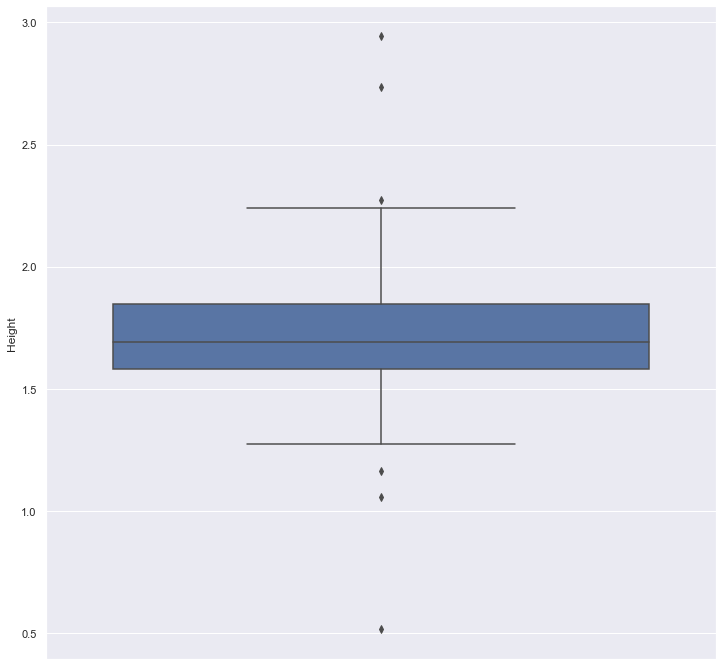

In [77]:
sns.boxplot(height_outlier, orient="vertical");

Uma primeira abordagem bem simples é encontrar os pontos do _box plot_ acima.

Tudo que estiver fora da faixa $[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$ é considerado um ponto anômalo para aquele padrão:

In [78]:
q1 = height_outlier.quantile(0.25)
q3 = height_outlier.quantile(0.75)
iqr = q3 - q1

non_outlier_interval_iqr = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]

print(f"Faixa considerada \"normal\": {non_outlier_interval_iqr}")

Faixa considerada "normal": [1.18575, 2.24175]


Agora podemos identificar quais pontos encontram-se fora desse intervalo, ou seja, podem ser considerados _outliers_:

In [79]:
outliers_iqr = height_outlier[(height_outlier < non_outlier_interval_iqr[0]) | (height_outlier > non_outlier_interval_iqr[1])]

outliers_iqr

29    0.516665
38    2.943781
48    1.058498
68    2.737088
91    2.272000
92    1.164000
Name: Height, dtype: float64

Se estivermos seguos de que esses pontos representam de fato _outliers_ e que sua remoção não traz prejuízo à nossa análise, então podemos removê-los:

In [80]:
height_no_outlier_iqr = height_outlier.drop(index=outliers_iqr.index)

Uma segunda abordagem é observar as estatísticas descritivas dos dados.

Repare no histograma abaixo:

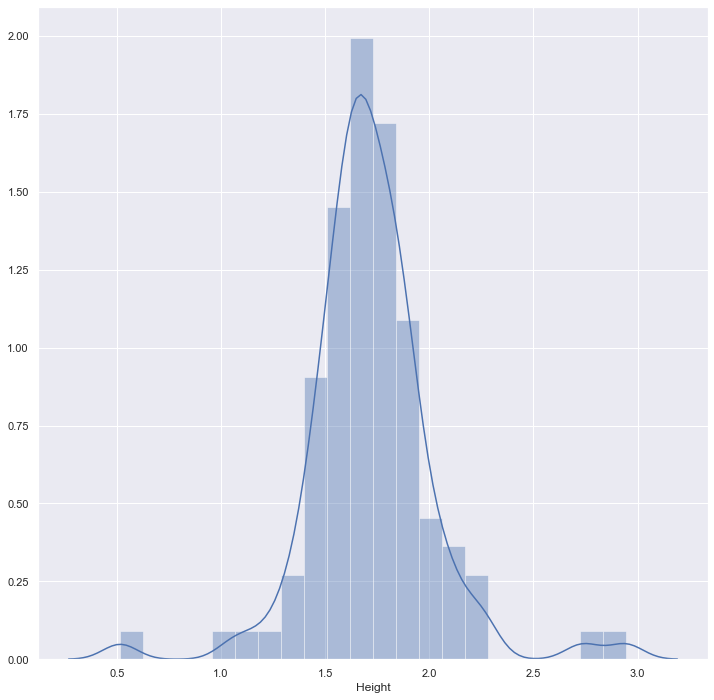

In [81]:
sns.distplot(height_outlier);

Dá para perceber que a maior parte dos dados concentra-se em torno da média (~ 1.7 m) e que apenas algumas observações encontram-se bastante distantes dela.

In [82]:
height_outlier_mean = height_outlier.mean()
height_outlier_std = height_outlier.std()

height_outlier_mean, height_outlier_std

(1.7181251474953014, 0.2948590174540895)

Um jeito de procurar por _outliers_ é ver quem se encontra fora do intervalo $[\bar{x} - k * \sigma, \bar{x} + k * \sigma]$, onde $k$ geralmente é 1.5, 2.0, 2.5 ou até 3.0.

Abaixo utilizamos o $k = 2$, pois esse valor faz sentido (alturas menores que 1.12 m ou maiores que 2.30 m fogem do nosso padrão):

In [83]:
non_outlier_interval_dist = [height_outlier_mean - 2 * height_outlier_std, height_outlier_mean + 2 * height_outlier_std]

non_outlier_interval_dist

[1.1284071125871225, 2.3078431824034804]

Novamente, conhecendo o intervalo, podemos identificar as observações que caem foram dele e removê-las:

In [84]:
outliers_dist = height_outlier[(height_outlier < non_outlier_interval_dist[0]) | (height_outlier > non_outlier_interval_dist[1])]

outliers_dist

29    0.516665
38    2.943781
48    1.058498
68    2.737088
Name: Height, dtype: float64

In [85]:
height_no_outlier_dist = height_outlier.drop(index=outliers_dist.index)

Até agora, nossas métodos de identificação de _outlier_ foram baseadas em estatísticas descritivas do nosso _data set_ (quantis, média e variância). Porém, alguns testes de hipóteses também existem.

Um deles é o teste de Grubb. Esse é um teste bastante simples, cuja estatística de teste $G$ depende dos valores extremos do conjunto e da média amostral:

$$G = \frac{\vert x_{\text{\{min ou max\}}} - \bar{x}\vert}{s}$$

onde $\bar{x}$ é a média amostral e $s$ é o desvio-padrão da amostra.

A hipótese nula, $H_{0}$, é de que não existem _outliers_ no _data set_. O teste de Grubb assume que os dados originam-se de uma distribuição normal, então pode ser válido testar essa hipótese antes.

Rejeitamos a hipótese nula se o valor de $G$ encontrado for superior ao valor crítico do teste, que é dado por

$$G_{\text{crítico}} = \frac{n - 1}{\sqrt{n}} \sqrt{\frac{t_{\alpha',n-2}^{2}}{n - 2 + t_{\alpha',n-2}^{2}}}$$

onde $n$ é o tamanho da amostra, $t$ é um valor com distribuição t-Student e $\alpha'$ é $\alpha/2n$ se o teste for bilateral (procuramos _outliers_ muito acima ou muito abaixo) ou $\alpha/n$ se o teste for unilateral (acreditamos que o _outlier_, se houver, está em somente uma das extremidades da distribuição).

Abaixo criamos algumas funções que nos auxiliam nos cálculos e na exibição dos resultados:

In [86]:
def grubb_test(g, n, alpha=0.05, tailed='two-tailed'):
  if tailed == 'two-tailed':
    critical = ((n - 1)/sqrt(n)) * sqrt(sct.t.isf(alpha/(2*n), n-2)**2/(n - 2 + sct.t.isf(alpha/(2*n), n-2)**2))
    
    return (g, critical, g > critical)
  elif tailed == 'one-tailed':
    critical = ((n - 1)/sqrt(n)) * sqrt(sct.t.isf(alpha/(n), n-2)**2/(n - 2 + sct.t.isf(alpha/(n), n-2)**2))
    
    return (g, critical, g > critical)
  else:
    raise ValueError(f"Invalid tailed argument")

In [87]:
def grubb_summary(result, decimals=10):
  return (
    f"Null hypothesis: there is no outliers in the data set\n"
    f"Test statistic: {np.round(result[0], decimals)}, "
    f"Grubb's critical value: {np.round(result[1], decimals)}, "
    f"Reject: {result[2]}"
  )

In [88]:
def next_outlier_candidate(data):
  sample_distances = (data - data.mean()).abs()
  candidate_idx = sample_distances.idxmax()
  candidate_value = data[candidate_idx]
  candidate_statistic = sample_distances.max()/data.std()
  
  return (candidate_idx, candidate_value, candidate_statistic, len(data))

Ao executarmos o teste de Grubb no nosso conjunto de alturas, encontramos alguns valores onde a hipótese nula é rejeitada, ou seja, há evidência de que o valor extremo é um _outlier_.

In [89]:
height_outlier_grubb = height_outlier.copy()
outliers_grubb = pd.Series()
has_outlier = True

while has_outlier:
  outlier_candidate = next_outlier_candidate(height_outlier_grubb)

  print(f"Index: {outlier_candidate[0]}, "
        f"Value: {np.round(outlier_candidate[1], 3)}, "
        f"Test statistic: {np.round(outlier_candidate[2], 3)}, "
        f"Sample size: {outlier_candidate[3]}\n")

  result = grubb_test(outlier_candidate[2], outlier_candidate[3])

  print(grubb_summary(result, 3))

  has_outlier = result[2]

  if has_outlier:
    height_outlier_grubb = height_outlier_grubb.drop(index=outlier_candidate[0])
    outliers_grubb.at[outlier_candidate[0]] = outlier_candidate[1]
    
  print(f"\n")

Index: 38, Value: 2.944, Test statistic: 4.157, Sample size: 100

Null hypothesis: there is no outliers in the data set
Test statistic: 4.157, Grubb's critical value: 3.384, Reject: True


Index: 29, Value: 0.517, Test statistic: 4.421, Sample size: 99

Null hypothesis: there is no outliers in the data set
Test statistic: 4.421, Grubb's critical value: 3.381, Reject: True


Index: 68, Value: 2.737, Test statistic: 4.219, Sample size: 98

Null hypothesis: there is no outliers in the data set
Test statistic: 4.219, Grubb's critical value: 3.377, Reject: True


Index: 48, Value: 1.058, Test statistic: 2.96, Sample size: 97

Null hypothesis: there is no outliers in the data set
Test statistic: 2.96, Grubb's critical value: 3.374, Reject: False




In [90]:
outliers_grubb

38    2.943781
29    0.516665
68    2.737088
dtype: float64

Abaixo comparamos os _outliers_ encontrados por cada um dos três métodos:

In [91]:
outliers = pd.Series({"IQR": outliers_iqr.index.values,
                      "Normal": outliers_dist.index.values,
                      "Grubb": outliers_grubb.index.values})

outliers.apply(np.sort)

IQR       [29, 38, 48, 68, 91, 92]
Normal            [29, 38, 48, 68]
Grubb                 [29, 38, 68]
dtype: object

## _Features_ de texto

Dados textuais são muito ricos e muito fáceis de serem encontrados. Diversos _data sets_ são compostos por documentos textuais e ainda um simples _scrapper_ pode coletar dezenas de milhares de documentos da Internet. Coleções de documentos são frequentemente chamadas de _corpus_ (plural, _corpora_).

Nosso objetivo aqui é somente mostrar como preprocessar de forma simples _features_ textuais. Para isso, utilizaremos o _data set_ 20 newsgroups, que contém milhares de documentos categorizados em 20 grupos (desde astronomia até carros).

Abaixo escolhemos somente três grupos para restringir nosso escopo:

In [92]:
categories = ["sci.crypt", "sci.med", "sci.space"]

newsgroups = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

Temos agora um _corpus_ com 1782 documentos:

In [93]:
len(newsgroups.data)

1782

Um exemplo de documento desse _corpus_ é mostrado abaixo:

In [94]:
document_idx = 4
documents_total = len(newsgroups.data)

print(f"> Document {document_idx} of {documents_total}:\n\n{newsgroups.data[document_idx]}")
print(f"> Category: {newsgroups.target_names[newsgroups.target[document_idx]]}")

> Document 4 of 1782:

From: billc@col.hp.com (Bill Claussen)
Subject: Re: Should I be angry at this doctor?
Organization: HP Colorado Springs Division
Lines: 5
Distribution: na
NNTP-Posting-Host: hpcspe17.col.hp.com


Report them to your local BBB (Better Business Bureau).

Bill Claussen


> Category: sci.med


Quando trabalhando com dados textuais, uma representação simples é ter:

* Cada documento em uma linha.
* Cada palavra (ou termo) em uma coluna.

Por exemplo, se nosso vocábulário (conjunto de todas palavras ou termos do _corpus_) tiver tamanho 10000 e tivermos 100 documentos, então nosso _data set_ será composto de 100 linhas e 10000 colunas.

O valor de cada célula, $x_{i, j}$, (interseção da linha $i$ com a coluna $j$) do _data set_ depende da tranformação que aplicarmos.

A transformação mais simples é a contagem de palavras no documento, ou seja, $x_{i, j}$ indica o número de ocorrências da palavra $j$ no documento $i$.

Isso pode ser obtido no sklearn pelo `CountVectorizer`:

In [95]:
count_vectorizer = CountVectorizer()
newsgroups_counts = count_vectorizer.fit_transform(newsgroups.data)

In [96]:
type(newsgroups_counts)

scipy.sparse.csr.csr_matrix

Abaixo escolhemos dez palavras contidas no _corpus_ para exemplificar:

In [97]:
words_idx = sorted([count_vectorizer.vocabulary_.get(f"{word.lower()}") for word in
                    [u"clipper", u"Kapor",
                     u"monitor", u"gibberish",
                     u"Banks", u"private",
                     u"study", u"group",
                     u"Colorado", u"Business"]])

pd.DataFrame(newsgroups_counts[:5, words_idx].toarray(), columns=np.array(count_vectorizer.get_feature_names())[words_idx])

,banks,business,clipper,colorado,gibberish,group,kapor,monitor,private,study
0,0,0,2,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,2,0,0
2,3,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,4,0,0,0,2
4,0,1,0,1,0,0,0,0,0,0


Por exemplo, o valor 2 na interseção do documento 0 com a coluna `clipper` indica que a palavra _clipper_ aparece duas vezes no documento 0. Obviamente é possível que uma mesma palavra apareça em múltiplos documentos e mais óbvio ainda que um documento contenha múltiplas palavras.

O problema com essa abordagem é que não temos como medir relevância dos termos. E se o  termo é super comum e aparece em quase todos documentos? E se o termo aparece muitas vezes no mesmo documento, mas poucas vezes nos outros?

Essas perguntas não podem ser respondidas simplesmente com a contagem de termos acima. Para isso, precisamos do tf-idf.

O tf-idf é uma estatística baseada no _corpus_ composta de outras duas estatísticas:

* $\text{tf}(t, d)$, ou _term frequency_, é uma medida de quantas vezes o termo $t$ aparece no documento $d$. Algumas opções estão disponíveis, mas a mais simples é a contagem do número de ocorrências do termo no documento, $f_{t, d}$, exatamente o que computamos acima. Essa é a forma como sklearn define $tf$:

$$\text{tf}(t, d) = f_{t, d}$$

* $\text{idf}(t)$, ou _inverse document frequency_, é uma medida de relevância do termo em todos documentos do _corpus_. O sklearn a computa, seguindo valores _default_, da seguinte forma:

$$\text{idf}(t) = \log{\frac{1+n}{1 + d_{t}}} + 1$$

onde $n$ é o número de documentos no _corpus_ e $d_{t}$ é o número de documentos no _corpus_ que contêm o termo $t$ ($0 < d_{t} \leq n$).

O tf-idf é calculado multiplicando esses dois valores:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t) = f_{t, d} \times \log{\frac{1+n}{1 + d_{t}}} + 1$$

O sklearn também normaliza todos documentos resultantes, ou seja todas linhas da matriz, para terem norma unitária. Em outras palavras, os elementos do vetor de tf-idf do documento $i$ são dados por:

$$\text{tf-idf}(i, j)_{\text{normalizado}} = \frac{\text{tf-idf}(i, j)}{\sqrt{\text{tf-idf}(i, 1)^{2} + \text{tf-idf}(i, 2)^{2} + \cdots + \text{tf-idf}(i, T)^{2}}}$$

onde $T$ é o número de termos do _corpus_, ou seja, o tamanho do vocabulário.

O tf-idf é sempre um valor não negativo e quanto mais alto, maior a relevância do termo.

Note como o tf aumenta de acordo com o número de ocorrências do termo no documento: quanto mais frequente o termo, mas relevante ele parece ser.

O idf é uma medida de "raridade" do termo através de todo _corpus_: quanto mais alto, menos o termo aparece no _corpus_ e consequentemente mais informação ele traz.

Multiplicando os dois, temos uma medida do quão relevante aquele termo é para aquele documento no _corpus_.

O sklearn provê um transformador, `TfidfTransformer`, que transforma de uma matriz de frequências, como a retornada pelo `CountVectorizer`, e retorna uma matriz de tf-idf:

In [98]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(newsgroups_counts)

newsgroups_tfidf = tfidf_transformer.transform(newsgroups_counts)

In [99]:
pd.DataFrame(newsgroups_tfidf[:5, words_idx].toarray(), columns=np.array(count_vectorizer.get_feature_names())[words_idx])

,banks,business,clipper,colorado,gibberish,group,kapor,monitor,private,study
0,0.000000,0.000000,0.081293,0.000000,0.000000,0.000000,0.096368,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.109894,0.000000,0.000000,0.179352,0.000000,0.000000
2,0.148152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048551,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.145223,0.000000,0.000000,0.000000,0.083477
4,0.000000,0.117248,0.000000,0.131568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Também podemos obter a matriz de tf-idf diretamente do _corpus_ sem ter que passar pela matriz de frequência com o transformador `TfidfVectorizer`:

In [100]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(newsgroups.data)

newsgroups_tfidf_vectorized = tfidf_vectorizer.transform(newsgroups.data)

In [101]:
pd.DataFrame(newsgroups_tfidf_vectorized[:5, words_idx].toarray(), columns=np.array(count_vectorizer.get_feature_names())[words_idx])

,banks,business,clipper,colorado,gibberish,group,kapor,monitor,private,study
0,0.000000,0.000000,0.081293,0.000000,0.000000,0.000000,0.096368,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.109894,0.000000,0.000000,0.179352,0.000000,0.000000
2,0.148152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048551,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.145223,0.000000,0.000000,0.000000,0.083477
4,0.000000,0.117248,0.000000,0.131568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Note como a matriz acima é exatamente igual a retornada pelo `TfidfTransformer`.

O resultado (igual da matriz de frequência) é um _data set_ com 1782 documentos e 33796 termos:

In [102]:
newsgroups_tfidf_vectorized.shape

(1782, 33796)

## Referências

* [Feature engineering](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html)

* [Feature Scaling with scikit-learn](http://benalexkeen.com/feature-scaling-with-scikit-learn/)

* [Anthony Goldbloom gives you the secret to winning Kaggle competitions](https://www.import.io/post/how-to-win-a-kaggle-competition/)

* [What are some best practices in Feature Engineering?](https://www.quora.com/What-are-some-best-practices-in-Feature-Engineering)

* [Discover Feature Engineering, How to Engineer Features and How to Get Good at It](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)

* [Fundamental Techniques of Feature Engineering for Machine Learning](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)

* [Feature Engineering Cookbook for Machine Learning](https://medium.com/@michaelabehsera/feature-engineering-cookbook-for-machine-learning-7bf21f0bcbae)

* [A Simple Guide to Scikit-learn Pipelines](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf)

* [Outlier detection with Scikit Learn](https://www.mikulskibartosz.name/outlier-detection-with-scikit-learn/)

* [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

* [WTF is TF-IDF?](https://www.kdnuggets.com/2018/08/wtf-tf-idf.html)
